# **Heart Rate Estimation Project : Chest Sweater**
### by Erica Brisigotti, Ekaterina Chueva & Nadillia Sahputra

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import fftpack, stats, signal
from scipy.optimize import curve_fit
import scipy.linalg as la
import pywt

## 1. **Data preparation**

### 1.1 **Selecting columns + accounting for offsets**

First, uploaded the data as a Pandas' dataframe and statistically analyzed through the appropriate Pandas' built-in function ( pandas.describe ).

In [2]:
file_name = '4_Chest_sweater.txt'
just_uploaded = pd.read_csv(file_name, delimiter='\t')
all_data = pd.DataFrame(just_uploaded)
display(all_data)
all_data.describe()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50,0.017279,0.534410,0.040437,-0.844081
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51,0.016416,0.535050,0.041231,-0.843654
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54,0.015920,0.534349,0.041780,-0.844081
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53,0.015192,0.531663,0.041749,-0.845790


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
count,14938.0,14938.0,1.493800e+04,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000
mean,5.0,100.0,1.555415e+09,-786.333273,-72.738192,636.756491,-2.817850,1.601171,0.287538,116.943634,42.895702,-125.815035,0.045135,-0.334707,-0.001663,0.673555
std,0.0,0.0,4.958891e+01,20.746661,15.663502,25.743684,2.073793,4.413089,0.469316,7.876135,4.863274,8.787037,0.031411,0.293897,0.017825,0.587030
min,5.0,100.0,1.555415e+09,-911.279000,-178.730000,264.984000,-172.195100,-174.634200,-10.243900,-592.000000,29.000000,-159.000000,0.001505,-0.487381,-0.432874,-0.907834
25%,5.0,100.0,1.555415e+09,-795.562000,-81.923000,623.847000,-3.292683,0.853659,0.121951,113.000000,39.000000,-131.000000,0.013244,-0.449538,-0.013245,0.887417
50%,5.0,100.0,1.555415e+09,-783.850000,-72.346000,640.378000,-2.804878,1.463415,0.243902,116.000000,43.000000,-127.000000,0.042618,-0.440352,-0.002686,0.894253
75%,5.0,100.0,1.555415e+09,-775.554000,-62.159000,653.127000,-2.317073,2.195122,0.487805,120.000000,46.000000,-122.000000,0.072328,-0.434706,0.008454,0.897549
max,5.0,100.0,1.555415e+09,687.836000,380.823000,755.607000,44.634150,154.756100,23.048780,146.000000,122.000000,-50.000000,0.788006,0.535050,0.043733,0.902310


The brief descriptive statistics provided by the <code>pandas.describe</code> function are particularly helpful in getting the time at which every measurement has been taken.
The **Log Freq** data, which represents the acquisition rate (in Hz), is constant and therefore allows for straigh-forward identification of the time interval between two successive measurements.

In [3]:
freq = all_data['Log Freq'].unique()[0] # Hz
time = np.arange(0,(len(all_data.index)/freq),(1/freq)) # seconds

This new time notation is adopted to substitute the "Timestamp" column, which is ambiguous because of its repetitive values.

The new notation simply consists of a vector with increasing values of time, representing the instant at which the corresponding measurements are taken.

All unnecessary columns can now be dropped: at the same time, a new column is added to store the new time variable.

In [4]:
data = all_data.drop(['MagnX','MagnY','MagnZ','qw','qi','qj','qk','Log Mode','Log Freq','Timestamp'], axis = 1)
data.insert(0, "Time", time)
data

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.00,687.836,380.823,580.354,-7.926829,8.048780,0.975610
1,0.01,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488
2,0.02,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100
3,0.03,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780
4,0.04,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463
...,...,...,...,...,...,...,...
14933,149.33,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854
14934,149.34,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854
14935,149.35,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854
14936,149.36,-894.992,-76.311,502.701,0.121951,1.463415,0.609756


Then offsets are taken from the 'README5' file (corresponds to the BCG datasets) and added to the corresponding variables:

In [5]:
acc_offsets = np.array([3.602701, -20.96658, 54.97186])

data['AccX'] += acc_offsets[0]
data['AccY'] += acc_offsets[1]
data['AccZ'] += acc_offsets[2]


data.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000,14938.000000
mean,74.685000,-782.730572,-93.704772,691.728351,-2.817850,1.601171,0.287538
std,43.123735,20.746661,15.663502,25.743684,2.073793,4.413089,0.469316
min,0.000000,-907.676299,-199.696580,319.955860,-172.195100,-174.634200,-10.243900
25%,37.342500,-791.959299,-102.889580,678.818860,-3.292683,0.853659,0.121951
50%,74.685000,-780.247299,-93.312580,695.349860,-2.804878,1.463415,0.243902
75%,112.027500,-771.951299,-83.125580,708.098860,-2.317073,2.195122,0.487805
max,149.370000,691.438701,359.856420,810.578860,44.634150,154.756100,23.048780


### 1.2 **representing the columns + selecting an appropriate time-window**

The columns are devided into two groups based on their physical quantity (linear acceleration and angular velocity). Their evolution in time is represented below.



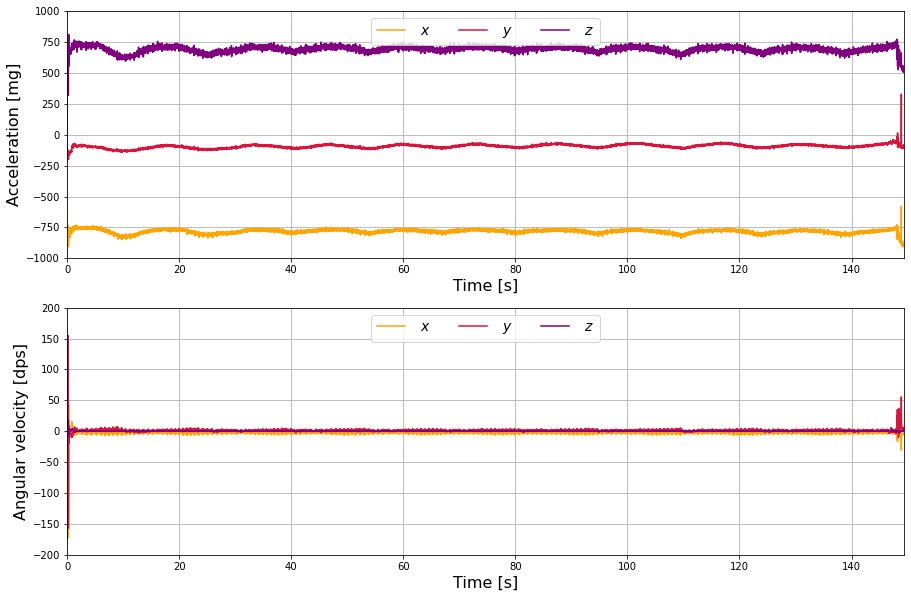

In [6]:
fig1 , ax1 = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 10))

ax1[0].plot(data['Time'], data['AccX'], '-' , label=' $x$ ' , color='orange' )
ax1[0].plot(data['Time'], data['AccY'], '-' , label=' $y$ ' , color='crimson' )
ax1[0].plot(data['Time'], data['AccZ'], '-' , label=' $z$ ' , color='purple' )
ax1[0].set_xlim( 0 , data['Time'].max() )
ax1[0].set_ylim( -1000, 1000)
ax1[0].set_xlabel( 'Time [s]' , fontsize = 16 )
ax1[0].set_ylabel( 'Acceleration [mg]' , fontsize = 16 )
ax1[0].legend( loc='upper center' , fontsize = 14 , ncol = 3 )
ax1[0].grid()

ax1[1].plot( data['Time'] , data['GyroX'] , '-' , label = ' $x$ ' , color='orange' )
ax1[1].plot( data['Time'] , data['GyroY'] , '-' , label = ' $y$ ' , color='crimson' )
ax1[1].plot( data['Time'] , data['GyroZ'] , '-' , label = ' $z$ ' , color='purple' )
ax1[1].set_xlim( 0 , data['Time'].max() )
ax1[1].set_ylim( -200, 200)
ax1[1].set_xlabel( 'Time [s]' , fontsize = 16 )
ax1[1].set_ylabel( 'Angular velocity [dps]' , fontsize = 16 )
ax1[1].legend( loc='upper center' , fontsize = 14  , ncol = 3 )
ax1[1].grid()


For further processing, only the middle part of the data will be taken into consideration. The purpose of this data elimination is to avoid fluctuation that regarded as a noise at the beginning and at the end of the data

The selection of an appropriate time window is then made based on the evolution of standard deviation.

In [7]:
def std_from_center( vect ):
    vect = np.array( vect )
    center_idx = int( vect.shape[0]/2 )
    std_down = [ np.std(vect[ (center_idx-idx):center_idx ] ) for idx in range(1,center_idx,1) ] 
    std_up = [ np.std( vect[ center_idx:(center_idx+idx) ] ) for idx in range(1,center_idx,1) ] 
    return np.concatenate((std_down[::-1],std_up))

7469
the percentage of measurements to keep is  97.06788057303521
1.69 146.69


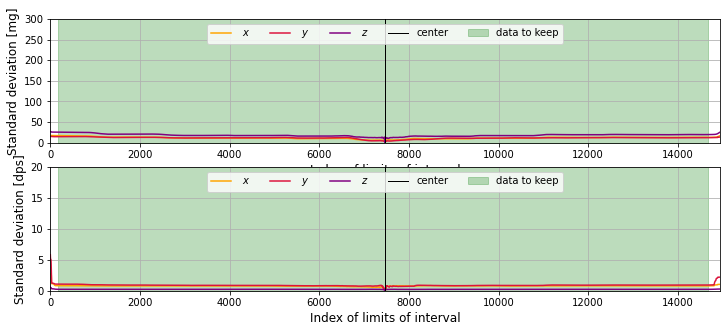

In [8]:
fig2,ax2 = plt.subplots( nrows = 2 , ncols = 1, figsize = ( 12 , 5 ) )
center_idx = int( data.shape[0]/2 )
down_cut = 7300
up_cut = 7200
print( center_idx )
print('the percentage of measurements to keep is ', (down_cut+up_cut)/data.shape[0]*100)
down_idx = center_idx-down_cut
up_idx = center_idx+up_cut
down_limit = ( data['Time'] )[ down_idx ]
up_limit =( data['Time'] )[ up_idx ]
print(down_limit,up_limit)

ax2[0].plot( std_from_center( data['AccX']) , '-' , label = ' $x$ ' , color='orange' )
ax2[0].plot( std_from_center( data['AccY']) , '-' , label = ' $y$ ' , color='crimson' )
ax2[0].plot( std_from_center( data['AccZ']) , '-' , label = ' $z$ ' , color='purple' )
ax2[0].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' , linewidth = 1 )
ax2[0].fill_betweenx( y = [0,300] , x1 = down_idx , x2 = up_idx , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax2[0].set_xlim( 0 , data.shape[0] )
ax2[0].set_ylim( 0 , 300 )
ax2[0].set_xlabel( 'Index of limits of interval' , fontsize = 12 )
ax2[0].set_ylabel( 'Standard deviation [mg]' , fontsize = 12 )
ax2[0].legend( loc = 'upper center' , ncol = 5 , fontsize = 10 )
ax2[0].grid()

ax2[1].plot( std_from_center( data['GyroX']) , '-' , label = ' $x$ ' , color='orange' )
ax2[1].plot( std_from_center( data['GyroY']) , '-' , label = ' $y$ ' , color='crimson' )
ax2[1].plot( std_from_center( data['GyroZ']) , '-' , label = ' $z$ ' , color='purple' )
ax2[1].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' , linewidth = 1 )
ax2[1].fill_betweenx( y = [0,20] , x1 = down_idx, x2 = up_idx , color='forestgreen' , alpha = 0.3 , label='data to keep' )
ax2[1].set_xlim( 0 , data.shape[0] )
ax2[1].set_ylim( 0 , 20 )
ax2[1].set_xlabel( 'Index of limits of interval' , fontsize = 12 )
ax2[1].set_ylabel( 'Standard deviation [dps]' , fontsize = 12 )
ax2[1].legend( loc = 'upper center' , ncol = 5 , fontsize = 10 )
ax2[1].grid()

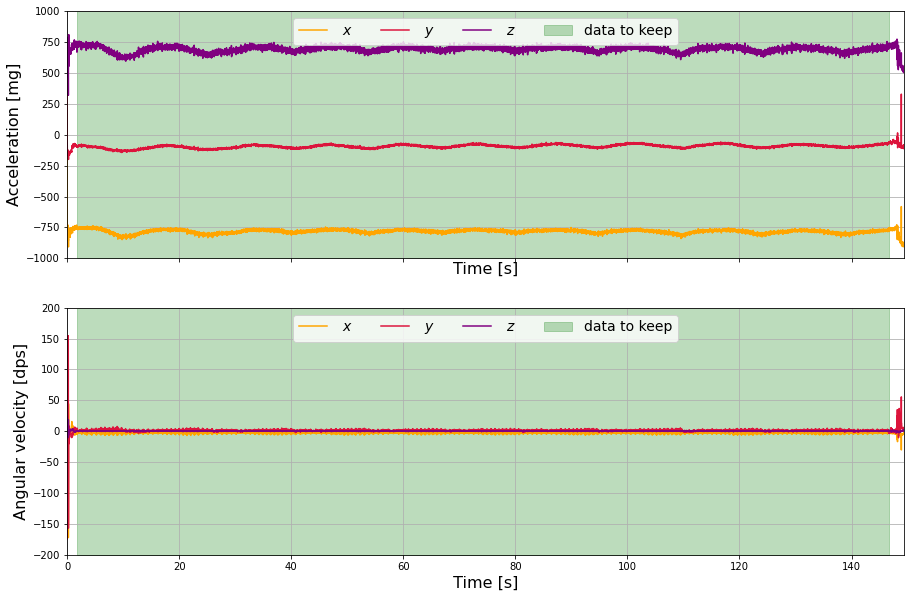

In [9]:
fig3, ax3 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = ( 15 , 10 ) )

ax3[0].plot( data['Time'] , data['AccX'] , '-' , label = ' $x$ ' , color = 'orange' )
ax3[0].plot( data['Time'] , data['AccY'] , '-' , label = ' $y$ ' , color = 'crimson' )
ax3[0].plot( data['Time'] , data['AccZ'] , '-' , label = ' $z$ ' , color = 'purple' )
ax3[0].fill_betweenx( y = [-1000,1000] , x1 = down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[0].set_xlim( min(data['Time']) , max(data['Time']) )
ax3[0].set_ylim( -1000 , 1000 )
ax3[0].set_xlabel( 'Time [s]' , fontsize = 16 )
ax3[0].set_ylabel( 'Acceleration [mg]' , fontsize = 16 )
ax3[0].legend( loc = 'upper center' , ncol = 4 , fontsize = 14 )
ax3[0].grid()

ax3[1].plot( data['Time'] , data['GyroX'] , '-' , label = ' $x$ ' , color='orange' )
ax3[1].plot( data['Time'] , data['GyroY'] , '-' , label = ' $y$ ' , color='crimson' )
ax3[1].plot( data['Time'] , data['GyroZ'] , '-' , label = ' $z$ ' , color='purple' )
ax3[1].fill_betweenx( y=[ -200 , 200 ] , x1=down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[1].set_xlim( min( data['Time'] ) , max( data['Time'] ) )
ax3[1].set_ylim( -200, 200 )
ax3[1].set_xlabel( ' Time [s] ' , fontsize = 16 )
ax3[1].set_ylabel( ' Angular velocity [dps] ', fontsize = 16 )
ax3[1].legend( loc = 'upper center' , ncol = 4 , fontsize = 14 )
ax3[1].grid()

The data corresponding to the outside of such window is dropped and the indexes of are adjusted to compensate for the cut.

In [10]:
ok_data = data.copy()
ok_data.drop( data[ data['Time'] <= down_limit ].index, inplace=True)
ok_data.drop( data[ data['Time'] >= up_limit ].index, inplace=True)
ok_data.set_index( np.arange(len(ok_data) ),inplace=True)

### 1.3 **PCA + choosing an appropriate combination of columns**

Before going further, the underlying structure of the variables must be investigated to determine the right combination of data to go through signal processing.   

In [11]:
def PCA_pairplot( vect ):
    vect_cov = np.cov( vect.T )
    vect_val , vect_vect = la.eig( vect_cov )
    vect_val = np.real_if_close( vect_val )
    perc = vect_val*100/vect_val.sum()
    return perc

#### 1.3.1 **PCA on acceleration**

In [12]:
print( 'the percentages corresponding the components of the acceleration are ' , PCA_pairplot( ok_data[ ['AccX','AccY','AccZ'] ] ) )

the percentages corresponding the components of the acceleration are  [83.17772569  7.23195494  9.59031937]


#### 1.3.2 **PCA on angular velocity**

In [13]:
print( 'the percentages corresponding the components of the angular velocity are ' , PCA_pairplot( ok_data[ ['GyroX','GyroY','GyroZ'] ] ) )

the percentages corresponding the components of the angular velocity are  [75.87261582 21.97778754  2.14959664]


#### 1.3.3 **Combining columns**

None of the columns can be discarded since all the corresponding percentages are non-negligible. They then can combined into a single variable initialized by normalization of the combined acceleration and combined gyro data. 

In [14]:
acc_norm = np.array( np.sqrt( ok_data['AccX']**2 + ok_data['AccY']**2 + ok_data['AccZ']**2 ))
gyro_norm = np.array( np.sqrt( ok_data['GyroX']**2 + ok_data['GyroY']**2 + ok_data['GyroZ']**2 ))

At the same time, the norms of the vectors can be normalized and summed together, as seen in literature.

In [15]:
time = np.array( ok_data['Time'] )
norm = acc_norm/np.linalg.norm(acc_norm) + gyro_norm/np.linalg.norm(gyro_norm)
to_analyze = pd.DataFrame( { 'Time' : time , 'Norm' : norm })

### 1.4. **Statistical analysis**

A statistical description of the combined dataset is another good measure that can implemented before the analysis.

In [16]:
std_description = pd.concat( [ to_analyze.describe() ,
                            pd.DataFrame( to_analyze.median() , columns=['median'] ).transpose() , 
                            pd.DataFrame( to_analyze.var(), columns=['variance'] ) .transpose() ] )
print(' the median to std ratio is ',
      np.round(std_description['Norm']['median']/std_description['Norm']['std']),':1') 
std_description

 the median to std ratio is  7.0 :1


,Time,Norm
count,14499.000000,14499.000000
mean,74.190000,0.016264
std,41.856451,0.002369
min,1.700000,0.009643
25%,37.945000,0.014732
50%,74.190000,0.015960
75%,110.435000,0.017409
max,146.680000,0.032609
median,74.190000,0.015960
variance,1751.962500,0.000006


In [17]:
to_analyze.corr()

,Time,Norm
Time,1.000000,-0.059394
Norm,-0.059394,1.000000


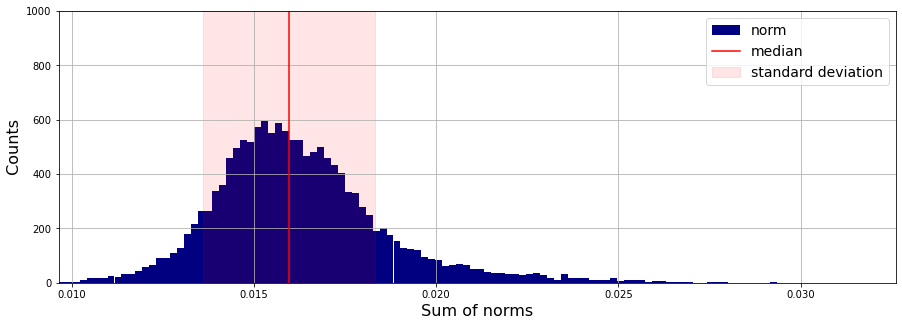

In [18]:
fig5, ax5 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 5 ) )
ax5.hist( norm , bins = int( np.sqrt( len(norm) ) ) , label = 'norm' , color = 'navy' )
ax5.axvline( x = std_description['Norm']['median'] , linestyle = '-' , color = 'r' , label = 'median' )
ax5.fill_betweenx( y=[ 0 , 1000 ] , x1 = (std_description['Norm']['median']-std_description['Norm']['std']) , 
                   x2 = (std_description['Norm']['median']+std_description['Norm']['std']) , 
                   color = 'red' , alpha = 0.1 , label = 'standard deviation' )
ax5.set_xlim( min( norm ) , max( norm ) )
ax5.set_ylim( 0 , +1000 )
ax5.set_xlabel( ' Sum of norms ' , fontsize = 16 )
ax5.set_ylabel( ' Counts ' , fontsize = 16 )
ax5.legend( loc = 'upper right'  , fontsize = 14 )
ax5.grid()
plt.show()

## 2. **Heart-rate estimation through FFT**

The first strategy to calculate heart rate (HR) is Fast Fourier Transform. The algorithm computes the discrete Fourier transform of the signal (in section 2.1), particularly its power. A desired frequency can be identified as the one of the local maxima of the power.

### 2.1 **FFT +  power plot**

In [19]:
def power_fft( vect , timestamp ):
    vect_fft = fftpack.fft( vect )
    vect_power = np.abs( vect_fft )
    vect_all_freq = fftpack.fftfreq( vect.size, d = timestep )
    return vect_fft , vect_power , vect_all_freq

timestep = 1/freq
norm_fft , norm_power , norm_all_freq = power_fft( np.asarray(to_analyze['Norm']) , timestep )

In [20]:
down_freq_lim = 40/60 # Hz
up_freq_lim = 100/60 # Hz

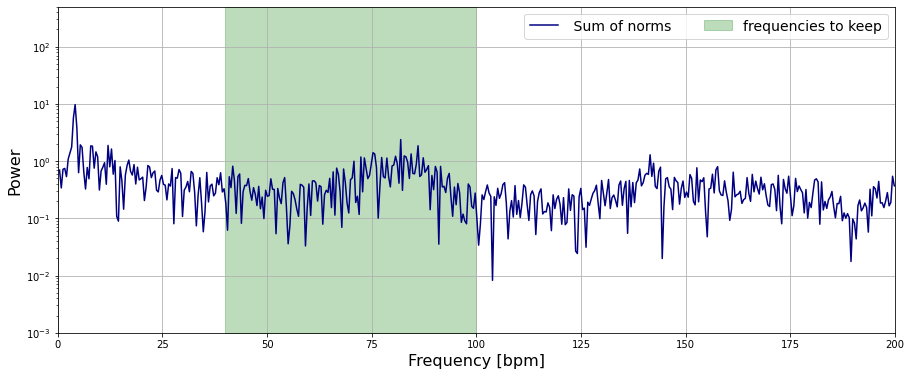

In [21]:
fig6 , ax6 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 6 ) )
ax6.plot( norm_all_freq[np.where(norm_all_freq > 0)]*60 , norm_power[np.where(norm_all_freq > 0)],
         '-' , label = ' Sum of norms ' , color = 'navy' )
ax6.fill_betweenx( y=[10**(-3), 5*10**2], x1 = down_freq_lim*60 , x2 = up_freq_lim*60 ,
                  color = 'forestgreen' , alpha = 0.3 , label = 'frequencies to keep' )
ax6.set_xlim(0, 200)
ax6.set_ylim(10**(-3), 5*10**2)
ax6.set_xlabel('Frequency [bpm]' , fontsize = 16 )
ax6.set_ylabel('Power' , fontsize = 16 )
ax6.set_yscale('log' )
ax6.legend( loc = 'upper right' , ncol = 2 , fontsize = 14 )
ax6.grid()
plt.show()

The spectrum in output to the direct FFT is symmetric with respect to the origin and includes a wide range of frequencies. As highlighted in the graphical representation above, only a small section of the spectrum can correspond to the heart-rate (which, at rest, is usually between 40-100 bpm).

The spectrum includes a wide range of frequencies. This can be caused by different sources, such as breathing, body movements, environmental noise, etc.

### 2.2 **Band-pass filter + heart-rate estimation via FFT**

The 40-100 bpm range of possible heart-rate is used to locate the desired local maxima can be identified. Such value will constitute the heart rate and its error will be estimated and can be used to make an approximation of band-pass filter. 

In [22]:
def band_pass_filter( vect_all_freq , vect_power, down_freq_lim , up_freq_lim ):
    vect_mask = np.where( ( down_freq_lim <= vect_all_freq ) & ( vect_all_freq <= up_freq_lim ) )
    vect_freq = vect_all_freq [ vect_mask ]
    vect_peak_freq = vect_freq [ vect_power [ vect_mask ].argmax() ]
    vect_err_peak_freq = ( vect_freq [ (vect_power [ vect_mask ]).argmax() + 1 ] - vect_freq [ (vect_power [ vect_mask ]).argmax() - 1 ] ) / 2
    return vect_mask , vect_freq , vect_peak_freq , vect_err_peak_freq

norm_mask , norm_freq , fft_peak_freq , fft_err_peak_freq = band_pass_filter( norm_all_freq , norm_power , down_freq_lim , up_freq_lim )

print('the peak frequency estimated from the sum of norms is ', fft_peak_freq*60 ,' ± ',fft_err_peak_freq*60 ,' bpm')

the peak frequency estimated from the sum of norms is  81.93668528864059  ±  0.4138216428719277  bpm


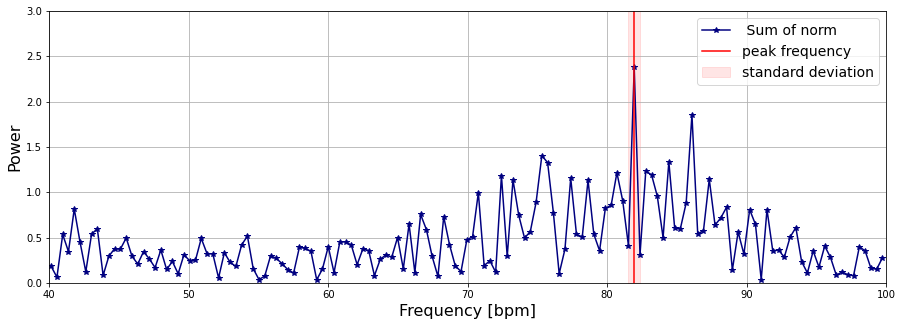

In [23]:
fig7, ax7 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 5 ) )
ax7.plot( norm_freq*60 , norm_power[norm_mask] , '-*' , label = ' Sum of norm' , color = 'navy' )
ax7.axvline( fft_peak_freq*60 , color='red' , label = 'peak frequency')
ax7.fill_betweenx( y=[ 0 , 3 ] , x1 = (fft_peak_freq-fft_err_peak_freq)*60 , 
                   x2 = (fft_peak_freq+fft_err_peak_freq)*60 , 
                   color = 'red' , alpha = 0.1 , label = 'standard deviation' )
ax7.set_xlim( down_freq_lim*60 , up_freq_lim*60 )
ax7.set_ylim( 0 , 3 )
ax7.set_xlabel( 'Frequency [bpm]' , fontsize = 16 )
ax7.set_ylabel( 'Power' , fontsize = 16 )
ax7.legend( loc = 'upper right' , fontsize = 14 )
ax7.grid()
plt.show()

### 2.3 **Filtering signal with FFT**

In [24]:
def filtered_power( vect_fft , vect_all_freq , down_freq_lim , up_freq_lim ):
    vect_filtered_fft = vect_fft.copy()
    vect_filtered_fft[ np.abs(vect_all_freq) >= 100/60 ] = 0
    vect_filtered_fft[ np.abs(vect_all_freq) <= 65/60 ] = 0
    vect_filtered = ( fftpack.ifft( vect_filtered_fft ) ).real
    return vect_filtered

norm_filtered = filtered_power( norm_fft , norm_all_freq , down_freq_lim , up_freq_lim )

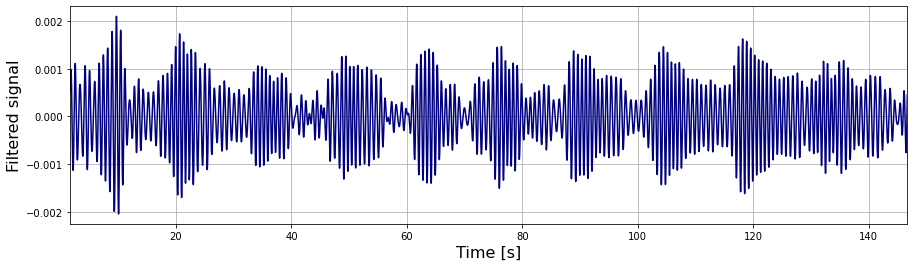

In [25]:
fig8 , ax8 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 4 ) )
ax8.plot(to_analyze['Time'] , norm_filtered , '-' , label = 'norm' , color = 'navy' )
ax8.set_xlim(min(to_analyze['Time']), max(to_analyze['Time']) )
ax8.set_xlabel( 'Time [s]' , fontsize = 16 )
ax8.set_ylabel( 'Filtered signal' , fontsize = 16 )
ax8.grid()
plt.show()

## 3. **Heart-rate estimation through Wavelet transform**

In this section, the band-pass filtered signal will be processed further with two methods of wavelet transforms: discrete wavelet transforms and continous wavelet transforms.

### 3.1 **Discrete Wavelet Transform**

The reverse biorthogonal 3.9 (rbio3.9) discrete wavelet is chosen to decompose the band-pass filtered signal. The choice of the wavelet was based on other studies [3].

As seen in the <a href="https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html"> <code>pywt.wavelet</code></a> documentation, the discrete wavelet takes other inputs such as the level of deconstruction, which was set to <code>level=6</code> after some tuning. Afterwards, the unnecessary coefficients were discarded by setting them to 0.


In [26]:
def dwt(time, vect, level):
    i = level+1
    coef = pywt.wavedec(vect , 'rbio3.9', level=i )

    for k in range (i):
        if (k != 2)&(k != 3): 
            coef[k] = np.zeros(coef[k].shape)
    dwt_sig = pywt.waverec( coef, 'rbio3.9' )
    fig9 , ax9 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 5 ) )
    ax9.plot(time, dwt_sig[:-1])
    ax9.set_xlabel ("Time [s]", fontsize=16)
    ax9.set_ylabel ("Magnitude freq [Hz]", fontsize=16)
    ax9.set_xlim(min(time),max(time))
    return dwt_sig

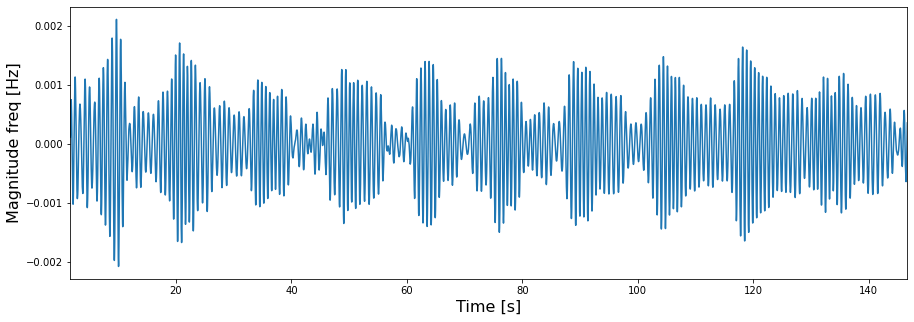

In [27]:
dwt_sig = dwt( time, norm_filtered , 6)

The temporal information in output to <code>dwt</code> is then analyzed: its peaks are identified to calculate the intervals between one another.

In [28]:
def peaks(time, vect):
    peaks, _ = signal.find_peaks(vect, width = 20) 
    
    num_peak = len(peaks)
    t  = time.max() - time.min()
    bps = num_peak/t
    print('BPM is', bps*60)

    plt.figure( figsize = ( 15 , 4 ) )
    plt.plot(time,vect[:-1])
    plt.plot(time[peaks], vect[peaks], "x")
    plt.xlim(min(time),max(time))
    plt.xlabel ("Time [s]", fontsize=16)
    plt.ylabel ("Magnitude freq [Hz]", fontsize=16)
    return (peaks)

BPM is 77.38998482549317


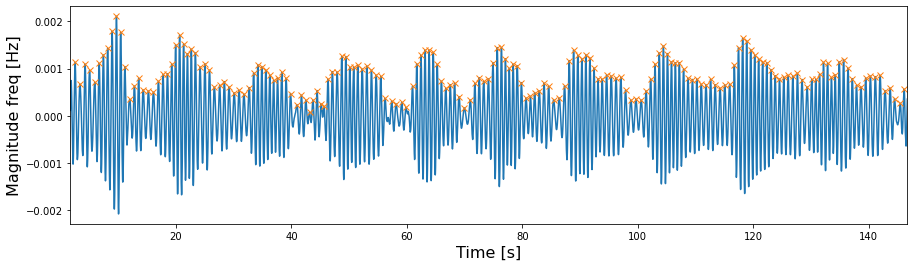

In [29]:
peak = peaks( time, dwt_sig)

# Below are the functions that are used for fitting.

In [30]:
def Gauss(x,A,mu,sigma):
    return A*np.exp(-(x - mu)**2/(2 * sigma**2)) 

def Cauchy(x,A,t,s):
    return A/(s*np.pi*(1 + ((x-t)/s)**2 ))

def Log_Logistics(x,A,a,b):
    return A*(b/a)*(x/a)**(b-1)/(1 + (x/a)**b)**2


Gaussian [5.45231092 0.75513688 0.07149179] [0.50909655 0.00770799 0.00770912]
Cauchy [1.30621782 0.75108084 0.07446612] [0.17560244 0.00973889 0.01419934]
Gaussian [5.42341835e-02 7.91778409e+01 7.21339017e+00] [0.00291213 0.44724425 0.44724648]
Log [ 1.01355664 79.37636733 17.27908321] [0.06305097 0.50407824 1.3215518 ]


(50.0, 120.0)

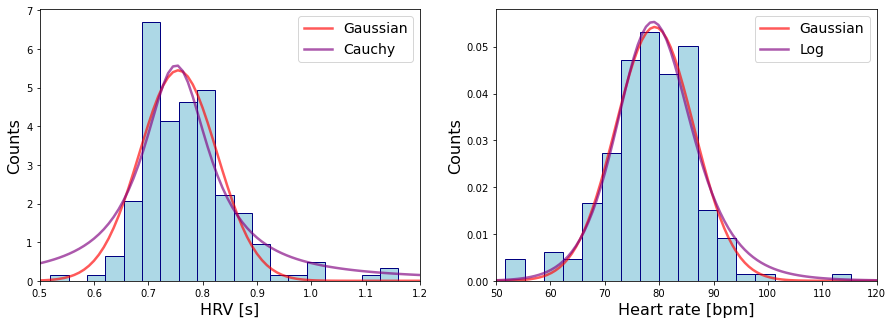

In [31]:
fig, ax = plt.subplots(ncols = 2, figsize = ( 15 , 5 ) )

# histogram and fit of HRV
times = np.asarray(time)
hrv = times[peak[1:]] - times[peak[:-1]] 
value_hrv, bins_hrv, _  = ax[0].hist(hrv,bins='auto', density = True,  stacked = True,
                                     color ='lightblue', ec = 'navy')
bins_mean_hrv=(bins_hrv[:-1]+bins_hrv[1:])/2
xspace_hrv = np.linspace(0.4,1.3,100)

opt_gauss_hrv, cov_gauss_hrv = curve_fit(Gauss, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1])
print('Gaussian', opt_gauss_hrv, np.sqrt(np.diag(cov_gauss_hrv)))
opt_cauchy, cov_cauchy = curve_fit(Cauchy, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1])
print('Cauchy', opt_cauchy, np.sqrt(np.diag(cov_cauchy)))

ax[0].plot(xspace_hrv, Gauss(xspace_hrv, *opt_gauss_hrv), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
ax[0].plot(xspace_hrv, Cauchy(xspace_hrv, *opt_cauchy), color='purple', linewidth=2.5, label='Cauchy', alpha=0.65)
ax[0].set_xlabel('HRV [s]' , fontsize = 16)
ax[0].set_ylabel('Counts' , fontsize = 16)
ax[0].legend( fontsize = 14 )
ax[0].set_xlim(0.5, 1.2)

    
# histogram and fit of BPM  
ffreq = 1/hrv
value_heart, bins_heart, _ = ax[1].hist(ffreq*60,bins='auto', density = True, stacked = True,
                                        color ='lightblue', ec = 'navy')
bins_mean_heart=(bins_heart[:-1]+bins_heart[1:])/2 
xspace_heart = np.linspace(45,120,100)

opt_gauss_heart, cov_gauss_heart = curve_fit(Gauss, xdata=bins_mean_heart, ydata=value_heart, p0=[0.07, 70, 5])
print('Gaussian', opt_gauss_heart, np.sqrt(np.diag(cov_gauss_heart)))
opt_log, cov_log = curve_fit(Log_Logistics, xdata=bins_mean_heart, ydata=value_heart, p0=[1, 70, 20])
print('Log', opt_log,np.sqrt(np.diag(cov_log)))

ax[1].plot(xspace_heart, Gauss(xspace_heart, *opt_gauss_heart), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
ax[1].plot(xspace_heart, Log_Logistics(xspace_heart, *opt_log), color='purple', linewidth=2.5, label='Log', alpha=0.65)
ax[1].set_xlabel('Heart rate [bpm]' , fontsize = 16)
ax[1].set_ylabel('Counts' , fontsize = 16)
ax[1].legend( fontsize = 14 )
ax[1].set_xlim(50, 120)

- DWT selected HRV is from Cauchy distribution
- DWT selected HR is from Gaussian distribution

In [32]:
dwt_peak_hrv = opt_cauchy[1]
dwt_peak_err_hrv = np.sqrt(np.diag(cov_cauchy))[1]
dwt_peak_hr = opt_gauss_heart[1]
dwt_peak_err_hr = np.sqrt(np.diag(cov_gauss_heart))[1]

### 3.2 **Continuous Wavelet Transform**

As seen in the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html"> <code>scipy.signal.find_peaks_cwt</code></a> documentation, the continuous wavelet takes inputs such as the potential width of the peaks, the type of wavelet (default: ricker) and the size of the window onto which the noise is calculated.


In [33]:
def cwt(time, waves):
    peakind = signal.find_peaks_cwt(waves, np.arange(15,50), window_size = 20)
    temp = np.array(time[peakind])
    fig,ax = plt.subplots( figsize=(15,7) )
    ax.plot(time,waves,'-')
    ax.plot(temp, waves[peakind],'*')
    plt.xlim(min(time),max(time))
    plt.xlabel ("Time [s]", fontsize=16)
    plt.ylabel ("Magnitude freq [Hz]", fontsize=16)
    print(len(peakind),' peaks were found')
    print(len(peakind)/(time.max() - time.min())*60, 'BPM')
    return temp

188  peaks were found
77.80383501172574 BPM


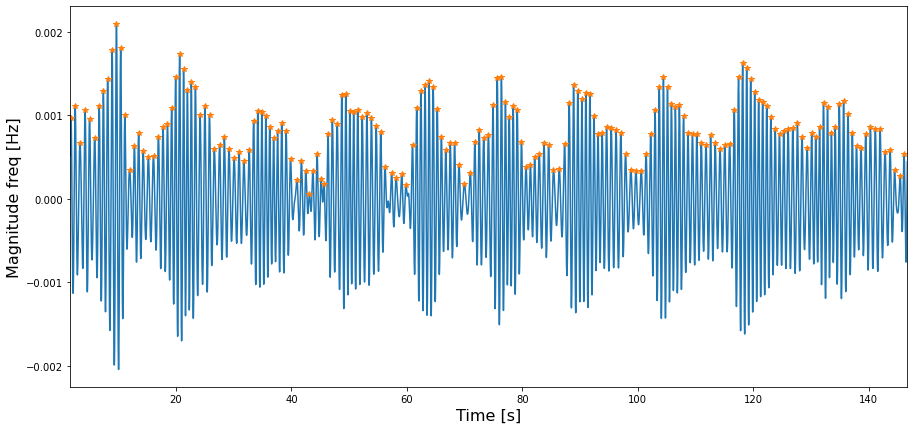

In [34]:
temp = cwt(time,norm_filtered)

Gaussian [5.58845267 0.75160737 0.06934515] [0.50221973 0.00719599 0.00719675]
Cauchy [1.29200013 0.74508755 0.07160113] [0.16956434 0.00917048 0.01331307]
Gaussian [5.42341835e-02 7.91778409e+01 7.21339017e+00] [0.00291213 0.44724425 0.44724648]
Log [ 1.00647369 79.59036925 17.64234679] [0.05600067 0.44274946 1.2069733 ]


(50.0, 120.0)

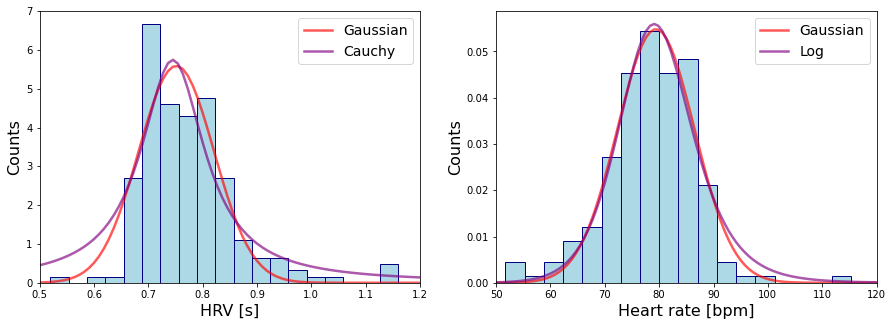

In [35]:
fig2, ax2 = plt.subplots(ncols = 2, figsize = ( 15 , 5 ) )

# histogram and fit of HRV
times2 = np.asarray(time)
hrv2= []
hrv2.append([temp[i+1]-temp[i] for i in range (len(temp)-1)])
value_hrv2, bins_hrv2, _  = ax2[0].hist(hrv2,bins='auto', density = True,  stacked = True,
                                     color ='lightblue', ec = 'navy')
bins_mean_hrv2=(bins_hrv2[:-1]+bins_hrv2[1:])/2
xspace_hrv2 = np.linspace(0.4,1.3,100)

opt_gauss_hrv2, cov_gauss_hrv2 = curve_fit(Gauss, xdata=bins_mean_hrv2, ydata=value_hrv2, p0=[16, 0.85, 0.1])
print('Gaussian', opt_gauss_hrv2, np.sqrt(np.diag(cov_gauss_hrv2)))
opt_cauchy2, cov_cauchy2 = curve_fit(Cauchy, xdata=bins_mean_hrv2, ydata=value_hrv2, p0=[16, 0.85, 0.1])
print('Cauchy', opt_cauchy2, np.sqrt(np.diag(cov_cauchy2)))

ax2[0].plot(xspace_hrv2, Gauss(xspace_hrv2, *opt_gauss_hrv2), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
ax2[0].plot(xspace_hrv2, Cauchy(xspace_hrv2, *opt_cauchy2), color='purple', linewidth=2.5, label='Cauchy', alpha=0.65)
ax2[0].set_xlabel('HRV [s]', fontsize = 16)
ax2[0].set_ylabel('Counts', fontsize = 16)
ax2[0].legend(fontsize = 14)
ax2[0].set_xlim(0.5, 1.2)

    
# histogram and fit of BPM  
ffreq2 = 1/np.asarray(hrv2)*60
ffreq2 = ffreq2.tolist()
value_heart2, bins_heart2, _ = ax2[1].hist(ffreq2,bins='auto', density = True, stacked = True,
                                        color ='lightblue', ec = 'navy')
bins_mean_heart2=(bins_heart2[:-1]+bins_heart2[1:])/2 
xspace_heart2 = np.linspace(45,120,100)

opt_gauss_heart2, cov_gauss_heart2= curve_fit(Gauss, xdata=bins_mean_heart2, ydata=value_heart2, p0=[0.07, 70, 5])
print('Gaussian', opt_gauss_heart, np.sqrt(np.diag(cov_gauss_heart)))
opt_log2, cov_log2 = curve_fit(Log_Logistics, xdata=bins_mean_heart2, ydata=value_heart2, p0=[1, 70, 20])
print('Log', opt_log2,np.sqrt(np.diag(cov_log2)))


ax2[1].plot(xspace_heart2, Gauss(xspace_heart2, *opt_gauss_heart2), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
ax2[1].plot(xspace_heart2, Log_Logistics(xspace_heart2, *opt_log2), color='purple', linewidth=2.5, label='Log', alpha=0.65)
ax2[1].set_xlabel('Heart rate [bpm]' , fontsize = 16)
ax2[1].set_ylabel('Counts', fontsize = 16)
ax2[1].legend(fontsize = 14)
ax2[1].set_xlim(50, 120)

- CWT selected HRV is from Cauchy distribution
- CWT selected HR is from Gaussian distribution

In [36]:
cwt_peak_hrv = opt_cauchy2[1]
cwt_peak_err_hrv = np.sqrt(np.diag(cov_cauchy2))[1]
cwt_peak_hr = opt_gauss_heart2[1]
cwt_peak_err_hr = np.sqrt(np.diag(cov_gauss_heart2))[1]

## 4. Respiratory rate estimation through FFT

The respiratory rate can be estimated through a similar strategy to the one presented in section 2.

The FFT-based algorithm selects a range of frequencies corresponding to the possible values of respiratory rate (9-25 breaths per minute). Then the respiratory rate is estimated as the local maxima, together with its error. 

In [37]:
breath_down_freq_lim = 9/60
breath_up_freq_lim = 25/60

In [38]:
def breath_band_pass_filter(vect_all_freq, vect_power, breath_down_freq_lim , breath_up_freq_lim ):
    vect_mask = np.where( ( breath_down_freq_lim <= vect_all_freq ) & ( vect_all_freq <= breath_up_freq_lim ) )
    vect_freq = vect_all_freq [ vect_mask ]
    vect_peak_freq = vect_freq [ vect_power [ vect_mask ].argmax() ]
    vect_err_peak_freq = (vect_freq[(vect_power[vect_mask]).argmax() + 1]
                          - vect_freq[(vect_power[vect_mask]).argmax() - 1])/2
    return vect_mask , vect_freq , vect_peak_freq , vect_err_peak_freq

breath_mask, breath_freq, breath_peak_freq, breath_err_peak_freq = breath_band_pass_filter( norm_all_freq,
                                                                                              norm_power,
                                                                                              breath_down_freq_lim, 
                                                                                              breath_up_freq_lim)

print('the peak frequency estimated from the sum of norms is ', breath_peak_freq*60 ,' ± ',breath_err_peak_freq*60 ,' bpm')

the peak frequency estimated from the sum of norms is  12.000827643285742  ±  0.4138216428719227  bpm


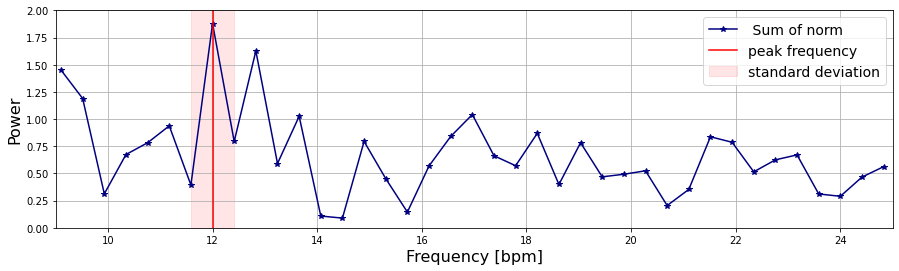

In [39]:
figb2, axb2 = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 4))

axb2.plot(breath_freq*60, norm_power[breath_mask] , '-*' , label = ' Sum of norm' , color = 'navy' )
axb2.axvline( breath_peak_freq*60 , color='red' , label = 'peak frequency')
axb2.fill_betweenx( y=[0, 2] , x1 = (breath_peak_freq-breath_err_peak_freq)*60 , 
                   x2 = (breath_peak_freq+breath_err_peak_freq)*60 , 
                   color = 'red' , alpha = 0.1 , label = 'standard deviation' )

axb2.set_xlim(breath_down_freq_lim*60, breath_up_freq_lim*60 )
axb2.set_ylim(0,2)
axb2.set_xlabel('Frequency [bpm]', fontsize = 16)
axb2.set_ylabel('Power', fontsize = 16)
axb2.legend(loc = 'upper right' , fontsize = 14)
axb2.grid()
plt.show()

## 5. **Conclusions**

The general algorithm that was implemented for center_sternum dataset (obtained with SCG method) works as well for this dataset (measured with BCG method).

The FFT shows that the **Heart Rate** is

In [40]:
print(np.round(fft_peak_freq*60,1),' ± ', np.round(fft_err_peak_freq*60,1),' bpm')

81.9  ±  0.4  bpm


This value is in alignment with the limit of a healthy human heart rate at rest (40 - 100 bpm). 


The final HR value obtained from wavelet processing also gives good results for both Continous (CWT) and Discrete Wavelet Transforms (DWT) 

In [41]:
print('DWT', np.round(dwt_peak_hr,1),' ± ', np.round(dwt_peak_err_hr,1),' bpm')

DWT 79.2  ±  0.4  bpm


In [42]:
print('CWT', np.round(cwt_peak_hr,1),' ± ', np.round(cwt_peak_err_hr,1),' bpm')

CWT 79.4  ±  0.4  bpm


The three HR values are statistically compatible.

Results for **Heart Rate Variation** were also estimated through wavelet anaysis:

In [43]:
print('DWT', np.round(dwt_peak_hrv,2),' ± ', np.round(dwt_peak_err_hrv,2),' s')

DWT 0.75  ±  0.01  s


In [44]:
print('CWT', np.round(cwt_peak_hrv,2),' ± ', np.round(cwt_peak_err_hrv,2),' s')

CWT 0.75  ±  0.01  s


Furthermore, the FFT was successfully extended to predict the range of **respiratory rate**, which resulted in

In [45]:
print(np.round(breath_peak_freq*60,1) ,' ± ', np.round(breath_err_peak_freq*60,1) ,' bpm')

12.0  ±  0.4  bpm
